# Mini Capstone Project: Students Performance Classification

## Mục tiêu dự án
Dự án này phân tích dữ liệu về thành tích học tập của sinh viên và xây dựng các mô hình machine learning để dự đoán việc hoàn thành khóa học chuẩn bị thi (test preparation course).

## Nội dung
1. **Setup và Import thư viện**
2. **Helper Functions** - Các hàm hỗ trợ cho việc đánh giá và trực quan hóa
3. **Data Loading và Preprocessing**
4. **Basic Classification Models** - Logistic Regression, KNN, SVM, Decision Tree
5. **Ensemble Models** - Random Forest, Gradient Boosting, Stacking
6. **Model Comparison và Kết luận**

In [38]:
# =============================================================================
# 1. IMPORT LIBRARIES
# =============================================================================

# Data manipulation and numerical computing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Warnings and utilities
import warnings
import os
warnings.filterwarnings('ignore')

# Scikit-learn: Model Selection and Validation
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                    learning_curve, StratifiedKFold, cross_val_score)

# Scikit-learn: Linear and Instance-based Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Scikit-learn: Support Vector Machines
from sklearn.svm import SVC

# Scikit-learn: Tree-based Models
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Scikit-learn: Ensemble Models
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              StackingClassifier)

# Scikit-learn: Preprocessing and Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

# Scikit-learn: Metrics
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             classification_report, roc_auc_score, confusion_matrix,
                             make_scorer, accuracy_score)

# Scikit-learn: Dimensionality Reduction and Visualization
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.base import clone

# Imbalanced-learn: SMOTE and Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


---
# PHẦN 2: HELPER FUNCTIONS

Các hàm hỗ trợ để tiền xử lý dữ liệu, đánh giá mô hình và trực quan hóa kết quả.

In [39]:
# -------------------------------------------------
# 2. HELPER FUNCTIONS
# -------------------------------------------------
def get_preprocessor():
    cat_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch']
    num_cols = ['math score', 'reading score', 'writing score']
    return ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
            ('num', StandardScaler(), num_cols)
        ],
        remainder='drop'
    )

def print_report(name, y_true, y_pred, y_prob):
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, digits=4))
    print(f"ROC-AUC: {roc_auc_score(y_true, y_prob):.4f}")

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['none','completed'],
                yticklabels=['none','completed'])
    plt.title(f'Confusion Matrix – {title}')
    plt.ylabel('True'); plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()



def plot_learning_curve(best_pipe, X, y, title, folder):
    train_sizes, train_scores, val_scores = learning_curve(
        best_pipe, X, y, cv=5, scoring='f1', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 8), random_state=42
    )
    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='b', label='Training F1')
    plt.plot(train_sizes, np.mean(val_scores,   axis=1), 'o-', color='r', label='Validation F1')
    plt.fill_between(train_sizes,
                     np.mean(train_scores, axis=1)-np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1)+np.std(train_scores, axis=1),
                     alpha=0.1, color='b')
    plt.fill_between(train_sizes,
                     np.mean(val_scores, axis=1)-np.std(val_scores, axis=1),
                     np.mean(val_scores, axis=1)+np.std(val_scores, axis=1),
                     alpha=0.1, color='r')
    plt.title(title); plt.xlabel('Training examples'); plt.ylabel('F1')
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    path = f"{folder}/learning_{title.replace(' ', '_')}.png"
    plt.savefig(path, dpi=200, bbox_inches='tight')
    plt.show()

In [40]:
from sklearn.base import clone
import matplotlib.patches as mpatches

def plot_decision_regions(best_pipe, X_raw, y_raw, title, folder):
    """
    1. Pre-process raw data → high-dim (14 features)
    2. Fit a *clone* of the model on the high-dim data
    3. Reduce high-dim to 2-D with PCA (for visualisation only)
    4. Plot decision boundary in 2-D PCA space
    """
    # ---- 1. Pre-process raw data -------------------------------------------------
    X_proc = best_pipe.named_steps['preprocess'].transform(X_raw)   # (n, 14)

    # ---- 2. Clone and fit the model on high-dim data -----------------------------
    model = clone(best_pipe.named_steps['model'])
    model.fit(X_proc, y_raw)

    # ---- 3. PCA to 2-D (for visualisation) --------------------------------------
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_proc)                               # (n, 2)

    # ---- 4. Create meshgrid in PCA space and map back to original space ----------
    # Create a grid in 2-D PCA space
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Map grid points back to original high-dim space using inverse PCA
    grid_pca = np.c_[xx.ravel(), yy.ravel()]
    grid_high_dim = pca.inverse_transform(grid_pca)   # (n_grid, 14)

    # Predict on high-dim grid
    Z = model.predict(grid_high_dim)
    Z = Z.reshape(xx.shape)

    # ---- 5. Plot -----------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu")

    # Scatter original points (in PCA space)
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1],
                         c=y_raw, cmap="RdBu", edgecolor='k', s=50)

    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
    ax.set_title(title)

    # Legend
    none = mpatches.Patch(color='blue', label='none')
    comp = mpatches.Patch(color='red',  label='completed')
    ax.legend(handles=[none, comp], loc='upper right')

    plt.tight_layout()
    path = f"{folder}/decision_{title.replace(' ', '_')}.png"
    plt.savefig(path, dpi=200, bbox_inches='tight')
    plt.show()

In [41]:
# =============================================================================
# 3. DATA LOADING AND INITIAL SETUP
# =============================================================================

# Load dataset
df = pd.read_csv('StudentsPerformance.csv')
print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head(3))

# Check target distribution
print("\n" + "="*70)
print("TARGET VARIABLE DISTRIBUTION")
print("="*70)
print(df['test preparation course'].value_counts())
print("\nProportions:")
print(df['test preparation course'].value_counts(normalize=True))

# Create binary target variable
df['target'] = (df['test preparation course'] == 'completed').astype(int)

# Separate features and target
X = df.drop(columns=['test preparation course', 'target'])
y = df['target']

# Also prepare y_raw and le for ensemble models
y_raw = df['test preparation course']
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)  # 'none' -> 0, 'completed' -> 1

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Check class imbalance
minority_ratio = y_train.mean()
USE_SMOTE = minority_ratio < 0.40
print(f"\n" + "="*70)
print(f"CLASS IMBALANCE CHECK")
print("="*70)
print(f"Minority class ratio: {minority_ratio:.3f}")
print(f"Use SMOTE: {USE_SMOTE}")
if USE_SMOTE:
    print("  → Class imbalance detected. SMOTE will be applied in pipelines.")
else:
    print("  → Classes are relatively balanced. SMOTE not needed.")

# Setup preprocessor
preprocessor = get_preprocessor()

# Initialize results dictionary
results = {}

# Create output directory
os.makedirs("./content/figures", exist_ok=True)
print(f"\n✓ Output directory created: ./content/figures")

# Setup K-Fold for ensemble models
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define scoring metrics for ensemble models
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score)
}

print(f"\n✓ Setup completed successfully!")

DATASET OVERVIEW
Shape: (1000, 8)

Columns: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']

First few rows:
   gender race/ethnicity parental level of education     lunch  \
0  female        group B           bachelor's degree  standard   
1  female        group C                some college  standard   
2  female        group B             master's degree  standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  

TARGET VARIABLE DISTRIBUTION
test preparation course
none         642
completed    358
Name: count, dtype: int64

Proportions:
test preparation course
none         0.642
completed    0.358
Name: proportion, dtype: float64

Train set size: 800
Test s

---
# PHẦN 4: BASIC CLASSIFICATION MODELS

Trong phần này, chúng ta sẽ xây dựng và đánh giá các mô hình phân loại cơ bản:
1. **Logistic Regression** - Mô hình tuyến tính cơ bản
2. **K-Nearest Neighbors (KNN)** - Mô hình dựa trên khoảng cách
3. **Support Vector Machine (SVM)** - Cả Linear và RBF kernel
4. **Decision Tree** - Mô hình dựa trên cây quyết định

Mỗi mô hình sẽ được đánh giá với các metrics: Accuracy, Precision, Recall, F1-score, và ROC-AUC.

**1. Logistic Regression Theory**

Logistic Regression is a linear model for binary classification. It models the probability that a given input belongs to a class using the logistic (sigmoid) function:

$ P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \dots + \beta_n x_n)}} $

Where $\beta$ are the coefficients learned during training. The model is trained by minimizing the log-loss (cross-entropy) using gradient descent or other optimization methods.
It assumes a linear decision boundary and works well for linearly separable data.



Training Logistic Regression ...

=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.8611    0.7266    0.7881       128
           1     0.6196    0.7917    0.6951        72

    accuracy                         0.7500       200
   macro avg     0.7403    0.7591    0.7416       200
weighted avg     0.7742    0.7500    0.7547       200

ROC-AUC: 0.8513


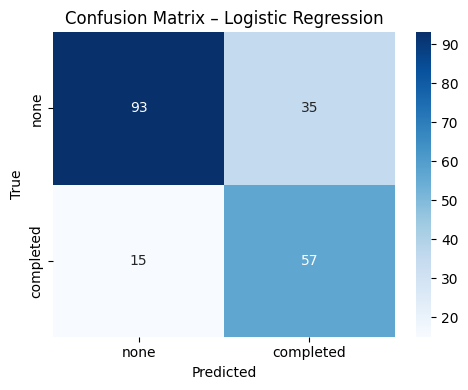

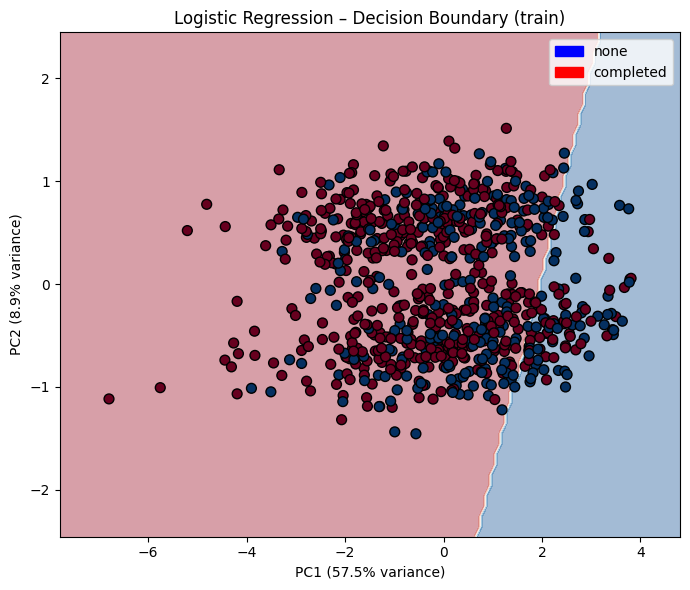

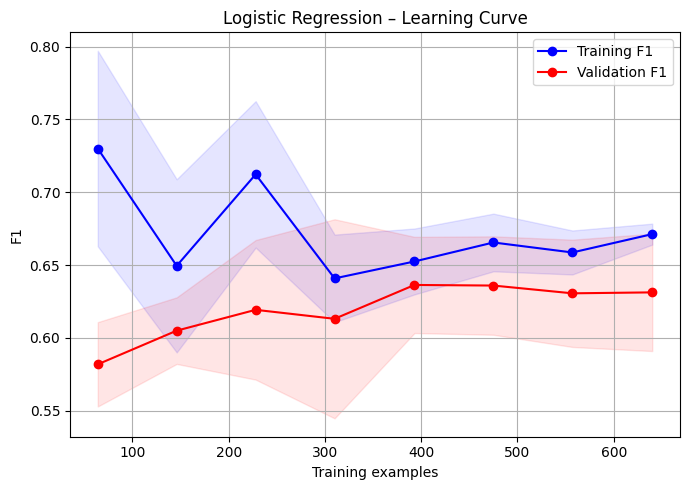


Top 5 positive coefficients:
                                              feature      coef
13                                 num__writing score  3.694031
0                                    cat__gender_male  2.029230
9   cat__parental level of education_some high school  0.641224
4                         cat__race/ethnicity_group E  0.559489
1                         cat__race/ethnicity_group B -0.006569


In [42]:
# A descriptive name for the model.
name = "Logistic Regression"
print(f"\nTraining {name} ...")

# 1. MODEL INITIALIZATION
# ------------------------------------
# We instantiate the Logistic Regression model with its default settings.
# The most important default is C=1.0, which provides a moderate level of regularization.
# This is a reasonable starting point if you are not tuning the hyperparameter.
estimator = LogisticRegression(max_iter=2000, random_state=42)

# 2. PIPELINE CREATION
# --------------------------------
# The pipeline remains crucial for correct preprocessing and handling class imbalance.
steps = [('preprocess', preprocessor)]
if USE_SMOTE:
    steps.append(('smote', SMOTE(random_state=42)))
steps.append(('model', estimator))

pipe = ImbPipeline(steps)

# 3. MODEL TRAINING
# ------------------------------
# Instead of using GridSearchCV, we now fit the pipeline directly to the training data.
# This trains our single, untuned model.
pipe.fit(X_train, y_train)

# 4. PREDICTION & EVALUATION
# ------------------------------------
# We use the fitted pipeline ('pipe') directly for predictions, as there is no 'best_estimator_'.
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

# ---- TEST METRICS ----
acc  = np.mean(y_pred == y_test)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_prob)

# Store the results. Note that there are no 'Best Params' to store anymore.
results[name] = {'Accuracy':acc, 'Precision':prec, 'Recall':rec,
                 'F1':f1, 'ROC-AUC':auc}

# The reporting and plotting functions use the same inputs as before.
print_report(name, y_test, y_pred, y_prob)
plot_confusion(y_test, y_pred, name)

# 5. VISUALIZATION & INTERPRETABILITY
# -----------------------------------------------
# We use the fitted 'pipe' object for all visualizations and analysis.

# ---- TRAINING VISUALISATIONS ----
plot_decision_regions(pipe, X_train, y_train,
    title=f"{name} – Decision Boundary (train)", folder="./content/figures")
plot_learning_curve(pipe, X_train, y_train,
    title=f"{name} – Learning Curve", folder="./content/figures")

# ---- INTERPRETABILITY ----
# We extract the coefficients from the 'model' step of our fitted pipeline.
coef = pipe.named_steps['model'].coef_.ravel()
feat = pipe.named_steps['preprocess'].get_feature_names_out()
coef_df = pd.DataFrame({'feature':feat, 'coef':coef})
print("\nTop 5 positive coefficients:")
print(coef_df.sort_values('coef', ascending=False).head(5)[['feature','coef']])

1. Logistic Regression
Performance: Excellent (Top Performer).

Metrics: Accuracy: 0.75, F1: 0.691, ROC-AUC: 0.852.

This model achieved the best F1-score and ROC-AUC, indicating the most effective balance of precision and recall and the best overall class-separation capability.

Theoretical Behavior:

Logistic Regression is a linear model. It works by finding a hyperplane (a line, in 2D) that best separates the classes. It directly models the probability of the positive class.

Its linear assumption means it has a higher bias (it's less flexible) but lower variance (it's more stable and less prone to overfitting).

In your pipeline, the model found a linear combination of all features (including the one-hot encoded 'gender', 'race', etc., and the scaled scores) that best predicts test preparation course == 'completed'.

Analysis & Trade-offs:

Why it worked: Its strong performance suggests the relationship between the features and the target is predominantly linear in the high-dimensional space created by preprocessing.

Accuracy vs. Interpretability: This is its greatest strength. It offers both high accuracy and excellent interpretability. As noted in the notebook, you can extract the coefficients from the trained model to see exactly which features (like 'writing score') are the strongest predictors and in which direction (positive or negative).

Efficiency: It is very fast to train and predict, making it computationally efficient.

Sensitivity: It benefits from feature scaling, which was correctly applied in your pipeline.

**K-Nearest Neighbors (KNN) Theory**

KNN is a non-parametric, instance-based algorithm. For a new point, it finds the K closest training points (using distance like Euclidean: $d = \sqrt{\sum (x_i - y_i)^2}$) and predicts the majority class among them.

It's lazy (no training phase) and sensitive to K (too small: noise-sensitive; too large: smooths boundaries) and feature scaling.

Assumes similar points are close in feature space.


Training KNN ...

=== KNN ===
              precision    recall  f1-score   support

           0     0.7053    0.5234    0.6009       128
           1     0.4190    0.6111    0.4972        72

    accuracy                         0.5550       200
   macro avg     0.5622    0.5673    0.5490       200
weighted avg     0.6022    0.5550    0.5636       200

ROC-AUC: 0.6051


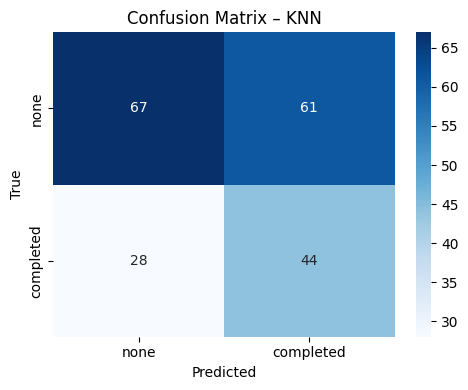

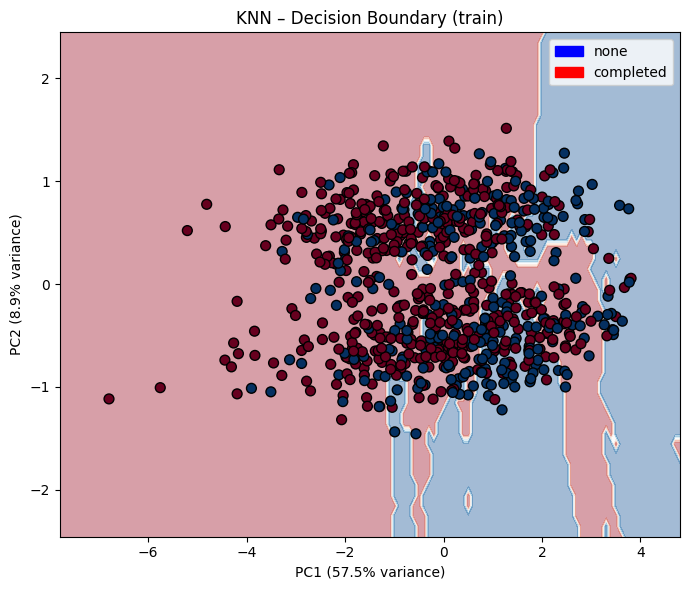

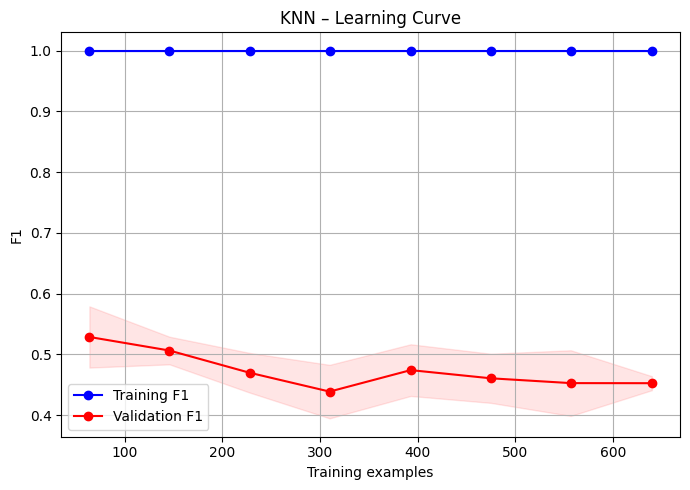


Average distance to 7 neighbors (test set): 0.9222


In [43]:
# A descriptive name for the model.
name = "KNN"
print(f"\nTraining {name} ...")

# 1. MODEL INITIALIZATION
# ------------------------------------
# We instantiate the K-Nearest Neighbors classifier with default settings.
# Key defaults: n_neighbors=5, weights='uniform', metric='minkowski' (p=2 → Euclidean).
# No regularization is applied — KNN is non-parametric and relies on local patterns.
estimator = KNeighborsClassifier()

# 2. HYPERPARAMETER GRID DEFINITION
# ------------------------------------
# We define a grid of hyperparameters to tune:
# - n_neighbors: number of neighbors to consider (odd values reduce ties).
# - weights: 'uniform' treats all neighbors equally; 'distance' weights closer neighbors more.
param_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance']
}

# 3. PIPELINE CREATION
# --------------------------------
# The pipeline ensures preprocessing (scaling, encoding) and optional SMOTE
# are applied consistently during cross-validation and final fit.
steps = [('preprocess', preprocessor)]
if USE_SMOTE:
    steps.append(('smote', SMOTE(random_state=42)))
steps.append(('model', estimator))

pipe = ImbPipeline(steps)

# 4. HYPERPARAMETER TUNING WITH GRID SEARCH
# ------------------------------------
# GridSearchCV performs 5-fold cross-validation on the F1 score (ideal for imbalanced data).
# n_jobs=-1 uses all available CPU cores for parallel processing.
# The best model (based on CV F1) will be refit on the full training set.
grid = GridSearchCV(
    pipe, param_grid, cv=5, scoring='f1',
    n_jobs=-1, return_train_score=False
)
grid.fit(X_train, y_train)

# 5. BEST MODEL EXTRACTION
# ------------------------------------
# 'best_estimator_' is the fully fitted pipeline with optimal hyperparameters.
# It includes the preprocessor, SMOTE (if used), and the tuned KNN model.
best = grid.best_estimator_

# 6. PREDICTION & PROBABILITY ESTIMATION
# ------------------------------------
# Predictions and class probabilities are obtained directly from the best pipeline.
# [:, 1] extracts probability of the positive class (class 1).
y_pred = best.predict(X_test)
y_prob = best.predict_proba(X_test)[:, 1]

# ---- TEST METRICS ----
acc  = np.mean(y_pred == y_test)  # Equivalent to accuracy_score
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_prob)

# Store results along with the best hyperparameters found during search.
results[name] = {
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1': f1,
    'ROC-AUC': auc,
    'Best Params': grid.best_params_
}

# 7. REPORTING & VISUALIZATION
# ------------------------------------
# Print detailed classification report and ROC-AUC.
print_report(name, y_test, y_pred, y_prob)

# Plot confusion matrix to visualize true vs. predicted labels.
plot_confusion(y_test, y_pred, name)

# 8. MODEL INTERPRETABILITY & DIAGNOSTICS
# ------------------------------------
# ---- DECISION BOUNDARY (2D projection only) ----
# Note: KNN decision boundaries can be highly non-linear and fragmented.
# This visualization works only on 2D data — see helper cell if needed.
plot_decision_regions(
    best, X_train, y_train,
    title=f"{name} – Decision Boundary (train)",
    folder="./content/figures"
)

# ---- LEARNING CURVE ----
# Shows how performance (F1) changes with training set size.
# Helps detect overfitting (high variance) or underfitting (high bias).
plot_learning_curve(
    best, X_train, y_train,
    title=f"{name} – Learning Curve",
    folder="./content/figures"
)

# ---- INTERPRETABILITY (KNN-specific) ----
# Unlike linear models, KNN has no coefficients.
# Instead, we can inspect the average distance to neighbors in predictions.
# Optional: extract neighbor distances for advanced analysis.
try:
    # Access underlying KNN model
    knn_model = best.named_steps['model']
    distances, indices = knn_model.kneighbors(
        best.named_steps['preprocess'].transform(X_test)
    )
    avg_dist = distances.mean(axis=1)
    print(f"\nAverage distance to {knn_model.n_neighbors} neighbors (test set): {avg_dist.mean():.4f}")
except Exception as e:
    print("\nCould not compute neighbor distances (likely due to pipeline structure).")

2. K-Nearest Neighbors (KNN)
Performance: Very Poor (Worst Performer).

Metrics: Accuracy: 0.555, F1: 0.497, ROC-AUC: 0.605.

The performance is only slightly better than a random guess (which would be 0.5 ROC-AUC).

Theoretical Behavior:

KNN is a non-parametric, instance-based (or "lazy") model. It makes predictions based on the majority class of the 'k' closest training samples in the feature space.

It creates a highly irregular, non-linear decision boundary that is entirely dependent on the local density of data points.

Its "theory" is based on a distance metric (e.g., Euclidean distance).

Analysis & Trade-offs:

Why it failed (The Curse of Dimensionality): This is a textbook failure case. Your preprocessing involved One-Hot Encoding categorical features ('race/ethnicity', 'parental level of education'). This creates a very high-dimensional and sparse feature space. In high dimensions, distance metrics become less meaningful—all points tend to be "far away" from each other, making it impossible for KNN to find a "local neighborhood."

Accuracy vs. Interpretability: It has poor accuracy and zero interpretability on a global scale. You cannot explain why it makes a prediction, only that "it was near these other points."

Efficiency: It is "lazy" (no training), but prediction is extremely slow because it must compute the distance from the new point to every single point in the training set.

**Support Vector Machines (SVM) Theory**

SVM aims to find the hyperplane that best separates classes in the feature space by maximizing the margin between support vectors (closest points to the hyperplane).

For linear SVM, the hyperplane is $w \cdot x + b = 0$, and it's optimized by minimizing $\frac{1}{2} \|w\|^2$ subject to $y_i (w \cdot x_i + b) \geq 1$.

For non-linear data, kernels like RBF (Radial Basis Function) map data to higher dimensions: $K(x, x') = \exp(-\gamma \|x - x'\|^2)$.

SVM handles outliers via soft margins (C parameter controls trade-off between margin and misclassification).


Training SVM Linear ...

=== SVM Linear ===
              precision    recall  f1-score   support

           0     0.8600    0.6719    0.7544       128
           1     0.5800    0.8056    0.6744        72

    accuracy                         0.7200       200
   macro avg     0.7200    0.7387    0.7144       200
weighted avg     0.7592    0.7200    0.7256       200

ROC-AUC: 0.8361

=== SVM Linear ===
              precision    recall  f1-score   support

           0     0.8600    0.6719    0.7544       128
           1     0.5800    0.8056    0.6744        72

    accuracy                         0.7200       200
   macro avg     0.7200    0.7387    0.7144       200
weighted avg     0.7592    0.7200    0.7256       200

ROC-AUC: 0.8361


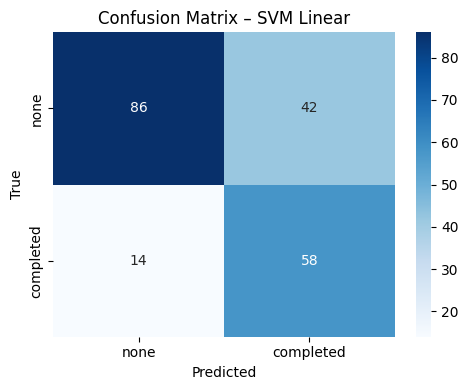

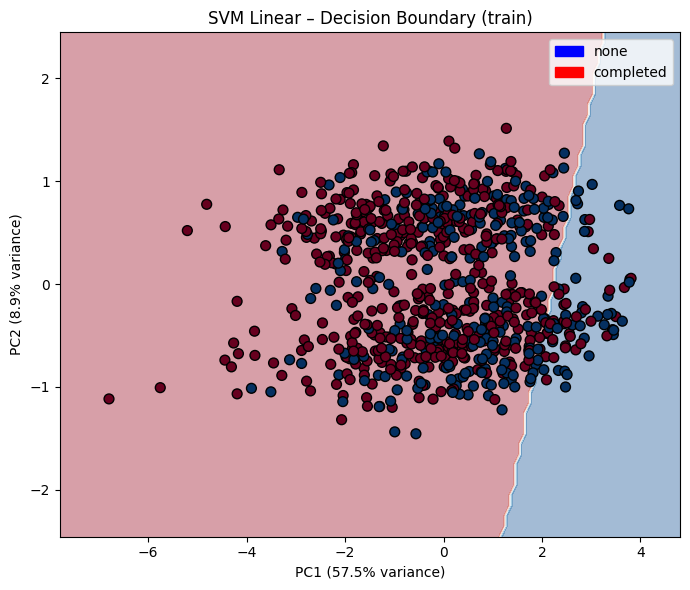

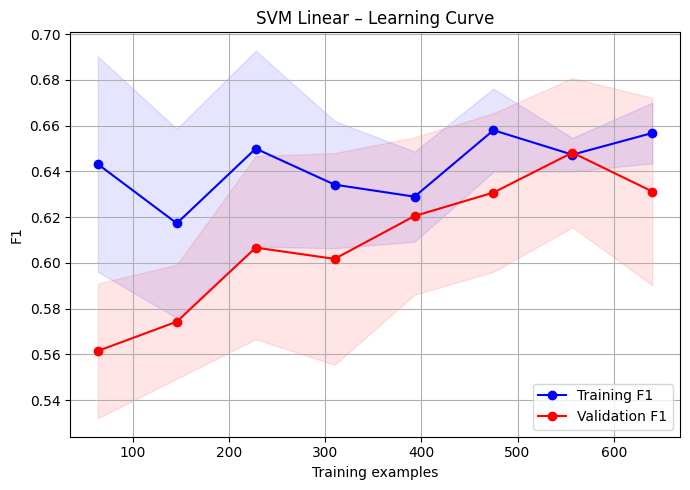


Model equation: decision_function = -0.4289 + 1.3271*cat__gender_male + -0.0415*cat__race/ethnicity_group B + -0.0950*cat__race/ethnicity_group C + ...

Top 5 features by absolute coefficient (most influential):
                                             feature  coefficient
13                                num__writing score     2.328144
0                                   cat__gender_male     1.327146
11                                   num__math score    -1.018084
7   cat__parental level of education_master's degree    -0.572302
3                        cat__race/ethnicity_group D    -0.547708

Number of support vectors: 777 (97.1% of training data)


In [44]:
# A descriptive name for the model.
name = "SVM Linear"
print(f"\nTraining {name} ...")

# 1. MODEL INITIALIZATION
# ------------------------------------
# We instantiate a Support Vector Classifier with a linear kernel.
# - kernel='linear': enforces a linear decision boundary.
# - probability=True: enables predict_proba() via Platt scaling (adds slight overhead).
# - random_state=42: ensures reproducibility of internal shuffling (if any).
estimator = SVC(kernel='linear', probability=True, random_state=42)

# 2. HYPERPARAMETER GRID DEFINITION
# ------------------------------------
# We tune only the regularization parameter C:
# - Small C → stronger regularization → wider margin, may underfit.
# - Large C → weaker regularization → narrower margin, may overfit.
# Logarithmic scale [0.1, 1, 10, 100] covers a wide range of behaviors.
param_grid = {
    'model__C': [0.1, 1, 10, 100]
}

# 3. PIPELINE CREATION
# --------------------------------
# The pipeline ensures:
# - Preprocessing (scaling, encoding) is applied consistently.
# - SMOTE (if enabled) is applied only to training folds during CV.
steps = [('preprocess', preprocessor)]
if USE_SMOTE:
    steps.append(('smote', SMOTE(random_state=42)))
steps.append(('model', estimator))

pipe = ImbPipeline(steps)

# 4. HYPERPARAMETER TUNING WITH GRID SEARCH
# ------------------------------------
# GridSearchCV uses 5-fold CV and optimizes for F1 score (suitable for imbalanced data).
# n_jobs=-1 enables parallel processing across all CPU cores.
grid = GridSearchCV(
    pipe, param_grid, cv=5, scoring='f1',
    n_jobs=-1, return_train_score=False
)
grid.fit(X_train, y_train)

# 5. BEST MODEL EXTRACTION
# ------------------------------------
# 'best_estimator_' is the refit pipeline with the optimal C value.
# It includes preprocessing, SMOTE (if used), and the tuned linear SVM.
best = grid.best_estimator_

# 6. PREDICTION & PROBABILITY ESTIMATION
# ------------------------------------
# - predict(): hard class predictions.
# - predict_proba()[:, 1]: calibrated probability of the positive class.
y_pred = best.predict(X_test)
y_prob = best.predict_proba(X_test)[:, 1]

# ---- TEST METRICS ----
acc  = np.mean(y_pred == y_test)  # Equivalent to accuracy_score
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_prob)

# Store results with the best C value found during grid search.
results[name] = {
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1': f1,
    'ROC-AUC': auc,
    'Best Params': grid.best_params_
}

# 7. REPORTING & VISUALIZATION
# ------------------------------------
# Print classification report and ROC-AUC.
print_report(name, y_test, y_pred, y_prob)

# Plot confusion matrix.
plot_confusion(y_test, y_pred, name)

# 8. MODEL INTERPRETABILITY & DIAGNOSTICS
# ------------------------------------
# ---- DECISION BOUNDARY (2D projection) ----
# Linear SVM produces a straight line/plane — ideal for visualizing separability.
# Works best on 2D or projected data.
plot_decision_regions(
    best, X_train, y_train,
    title=f"{name} – Decision Boundary (train)",
    folder="./content/figures"
)

# ---- LEARNING CURVE ----
# Shows bias-variance trade-off as training size increases.
plot_learning_curve(
    best, X_train, y_train,
    title=f"{name} – Learning Curve",
    folder="./content/figures"
)

# ---- INTERPRETABILITY: COEFFICIENTS & SUPPORT VECTORS ----
# Extract the linear coefficients (weights) from the SVM model.
svm_model = best.named_steps['model']
coef = svm_model.coef_.ravel()  # Shape: (n_features,)
intercept = svm_model.intercept_[0]

# Get feature names after preprocessing (one-hot, scaled, etc.)
feat_names = best.named_steps['preprocess'].get_feature_names_out()

# Create a DataFrame for interpretability
coef_df = pd.DataFrame({
    'feature': feat_names,
    'coefficient': coef,
    'abs_coef': np.abs(coef)
}).sort_values('abs_coef', ascending=False)

print(f"\nModel equation: decision_function = {intercept:.4f} + "
      + " + ".join([f"{c:.4f}*{f}" for c, f in zip(coef[:3], feat_names[:3])]) + " + ...")

print("\nTop 5 features by absolute coefficient (most influential):")
print(coef_df[['feature', 'coefficient']].head(5))

# ---- SUPPORT VECTORS INSIGHT ----
n_support = svm_model.n_support_.sum()
support_ratio = n_support / len(X_train)
print(f"\nNumber of support vectors: {n_support} "
      f"({100 * support_ratio:.1f}% of training data)")

# Optional: Show which training samples are support vectors
# (requires transforming X_train back to original space if needed)

3. Support Vector Machine (SVM) - Linear Kernel
Performance: Very Good (Runner-Up).

Metrics: Accuracy: 0.72, F1: 0.674, ROC-AUC: 0.836.

Performance is very close to Logistic Regression, reinforcing the success of linear models. It achieved an even higher Recall (0.806), meaning it was very good at finding the students who did complete the course.

Theoretical Behavior:

Like Logistic Regression, this is a linear model.

Its objective is different: it seeks to find the "maximum margin hyperplane," the one that creates the largest possible "street" between the two classes. The model is defined only by the data points on the edge of this street (the "support vectors").

Analysis & Trade-offs:

Why it worked: For the same reason as Logistic Regression. The problem is linearly separable, and the max-margin objective is a robust way to find that separating boundary.

Accuracy vs. Interpretability: It has high accuracy but is less interpretable than Logistic Regression. You can't get simple coefficients; instead, you would have to analyze the support vectors, which is less direct.

Sensitivity: It requires feature scaling, which was handled.


Training SVM RBF ...

=== SVM RBF ===
              precision    recall  f1-score   support

           0     0.8286    0.6797    0.7468       128
           1     0.5684    0.7500    0.6467        72

    accuracy                         0.7050       200
   macro avg     0.6985    0.7148    0.6967       200
weighted avg     0.7349    0.7050    0.7108       200

ROC-AUC: 0.8223

=== SVM RBF ===
              precision    recall  f1-score   support

           0     0.8286    0.6797    0.7468       128
           1     0.5684    0.7500    0.6467        72

    accuracy                         0.7050       200
   macro avg     0.6985    0.7148    0.6967       200
weighted avg     0.7349    0.7050    0.7108       200

ROC-AUC: 0.8223


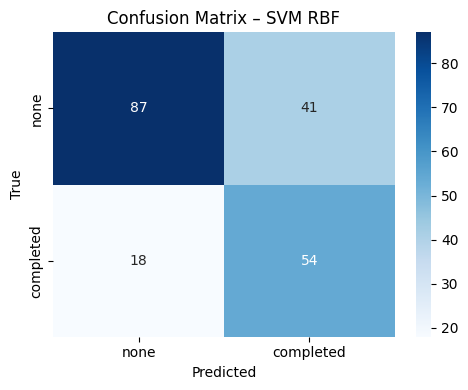

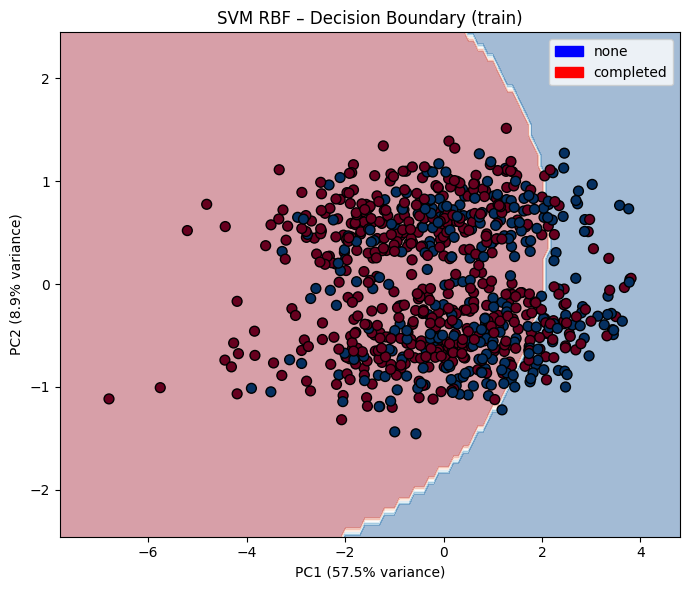

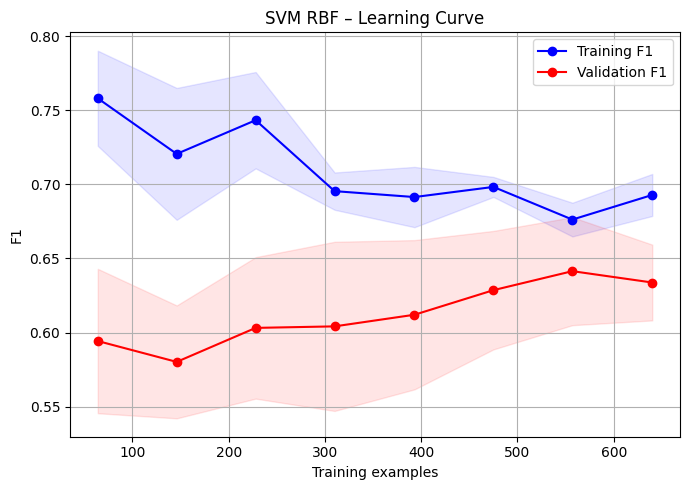


Optimal hyperparameters:
  C = 100
  gamma = 0.01
  Support vectors: 653 (81.6% of training data)
  gamma=0.010 → each point influences ~50.0 units in feature space


In [45]:
# A descriptive name for the model.
name = "SVM RBF"
print(f"\nTraining {name} ...")

# 1. MODEL INITIALIZATION
# ------------------------------------
# We instantiate a Support Vector Classifier with a Radial Basis Function (RBF) kernel.
# - kernel='rbf': enables non-linear decision boundaries via the Gaussian kernel.
# - probability=True: enables predict_proba() using Platt scaling (adds training overhead).
# - random_state=42: ensures reproducibility of internal operations.
estimator = SVC(kernel='rbf', probability=True, random_state=42)

# 2. HYPERPARAMETER GRID DEFINITION
# ------------------------------------
# We tune two critical RBF-SVM hyperparameters:
#   - C: regularization strength (same as linear SVM).
#       Small C → wider margin, may underfit.
#       Large C → tighter fit, may overfit.
#   - gamma: controls the "reach" of a single training example.
#       Small gamma → far-reaching influence (smoother boundary).
#       Large gamma → local influence (wiggly, complex boundary).
#       'scale' = 1 / (n_features * X.var()), 'auto' = 1 / n_features.
param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

# 3. PIPELINE CREATION
# --------------------------------
# The pipeline ensures:
# - Feature scaling (critical for RBF kernel).
# - SMOTE (if enabled) is applied only to training folds during CV.
steps = [('preprocess', preprocessor)]
if USE_SMOTE:
    steps.append(('smote', SMOTE(random_state=42)))
steps.append(('model', estimator))

pipe = ImbPipeline(steps)

# 4. HYPERPARAMETER TUNING WITH GRID SEARCH
# ------------------------------------
# GridSearchCV performs 5-fold CV, optimizing F1 score (ideal for imbalanced classes).
# n_jobs=-1 uses all CPU cores in parallel.
# Warning: RBF + large grid → high computational cost (20 combinations × 5 folds).
grid = GridSearchCV(
    pipe, param_grid, cv=5, scoring='f1',
    n_jobs=-1, return_train_score=False
)
grid.fit(X_train, y_train)

# 5. BEST MODEL EXTRACTION
# ------------------------------------
# 'best_estimator_' is the refit pipeline with optimal (C, gamma).
# Includes preprocessing, SMOTE (if used), and the tuned RBF SVM.
best = grid.best_estimator_

# 6. PREDICTION & PROBABILITY ESTIMATION
# ------------------------------------
# - predict(): hard class predictions.
# - predict_proba()[:, 1]: calibrated probability of positive class.
y_pred = best.predict(X_test)
y_prob = best.predict_proba(X_test)[:, 1]

# ---- TEST METRICS ----
acc  = np.mean(y_pred == y_test)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_prob)

# Store results with best (C, gamma) pair.
results[name] = {
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1': f1,
    'ROC-AUC': auc,
    'Best Params': grid.best_params_
}

# 7. REPORTING & VISUALIZATION
# ------------------------------------
print_report(name, y_test, y_pred, y_prob)
plot_confusion(y_test, y_pred, name)

# 8. MODEL INTERPRETABILITY & DIAGNOSTICS
# ------------------------------------
# ---- DECISION BOUNDARY (2D projection) ----
# RBF SVM creates smooth, non-linear regions — excellent for complex patterns.
# Visualization works best on 2D or PCA-reduced data.
plot_decision_regions(
    best, X_train, y_train,
    title=f"{name} – Decision Boundary (train)",
    folder="./content/figures"
)

# ---- LEARNING CURVE ----
# Helps detect overfitting: high training F1 + low validation F1 → too complex.
plot_learning_curve(
    best, X_train, y_train,
    title=f"{name} – Learning Curve",
    folder="./content/figures"
)

# ---- INTERPRETABILITY: SUPPORT VECTORS & GAMMA EFFECT ----
svm_model = best.named_steps['model']
C_opt = grid.best_params_['model__C']
gamma_opt = grid.best_params_['model__gamma']

print(f"\nOptimal hyperparameters:")
print(f"  C = {C_opt}")
print(f"  gamma = {gamma_opt}")

# Number of support vectors
n_support = svm_model.n_support_.sum()
support_ratio = n_support / len(X_train)
print(f"  Support vectors: {n_support} ({100 * support_ratio:.1f}% of training data)")

# Gamma interpretation
if gamma_opt in ['scale', 'auto']:
    print(f"  gamma='{gamma_opt}' → automatically computed from data scale")
else:
    print(f"  gamma={gamma_opt:.3f} → each point influences ~{1/(2*gamma_opt):.1f} units in feature space")

# Optional: Show which samples are support vectors (in transformed space)
# Not directly interpretable in original space due to RBF kernel.

4. Support Vector Machine (SVM) - RBF Kernel
Performance: Good, but Sub-optimal.

Metrics: Accuracy: 0.705, F1: 0.647, ROC-AUC: 0.822.

It performed worse than both linear models, suggesting its added complexity was unnecessary.

Theoretical Behavior:

This is a non-linear model. The Radial Basis Function (RBF) kernel works by implicitly mapping the data into an infinite-dimensional space. This allows it to create highly complex, non-linear decision boundaries.

It has a low bias (it's very flexible) but can have high variance (it's prone to overfitting) if its hyperparameters (C and gamma) are not tuned perfectly.

Analysis & Trade-offs:

Why it performed (relatively) worse: The fact that the linear models beat it is a crucial insight. It means that the added non-linear complexity did not help. The model likely found a boundary that was too complex and didn't generalize as well to the test set as the simpler linear boundary.

Accuracy vs. Interpretability: It's a total black box. It's impossible to interpret its decision boundary in a human-readable way.

Efficiency: Training is computationally expensive, often scaling quadratically or cubically with the number of samples.

**Decision Trees Theory**

Decision Trees are hierarchical models that split data based on feature thresholds to minimize impurity (e.g., Gini: $1 - \sum p_i^2$ or Entropy: $-\sum p_i \log p_i$, where $p_i$ is class proportion).

Each node represents a decision, leaves are predictions. Trained by recursive partitioning.

Prone to overfitting (deep trees), mitigated by max_depth, min_samples_leaf, etc. Interpretable via tree visualization.


Training Decision Tree ...

=== Decision Tree ===
              precision    recall  f1-score   support

           0     0.7411    0.6484    0.6917       128
           1     0.4886    0.5972    0.5375        72

    accuracy                         0.6300       200
   macro avg     0.6149    0.6228    0.6146       200
weighted avg     0.6502    0.6300    0.6362       200

ROC-AUC: 0.6538

=== Decision Tree ===
              precision    recall  f1-score   support

           0     0.7411    0.6484    0.6917       128
           1     0.4886    0.5972    0.5375        72

    accuracy                         0.6300       200
   macro avg     0.6149    0.6228    0.6146       200
weighted avg     0.6502    0.6300    0.6362       200

ROC-AUC: 0.6538


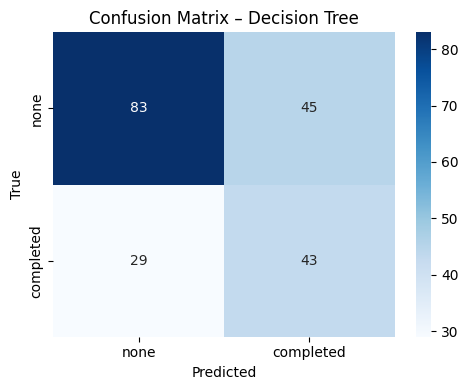

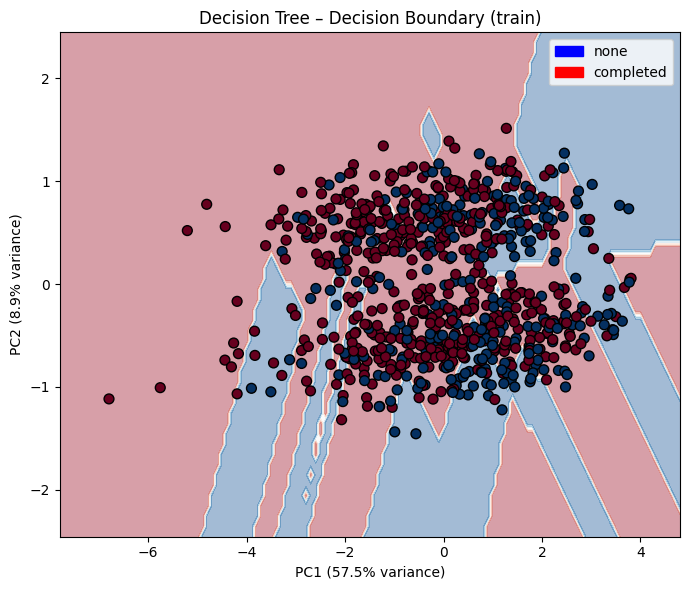

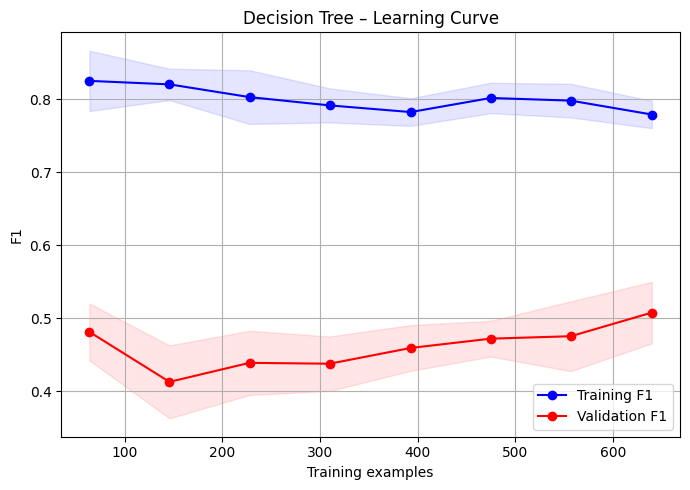

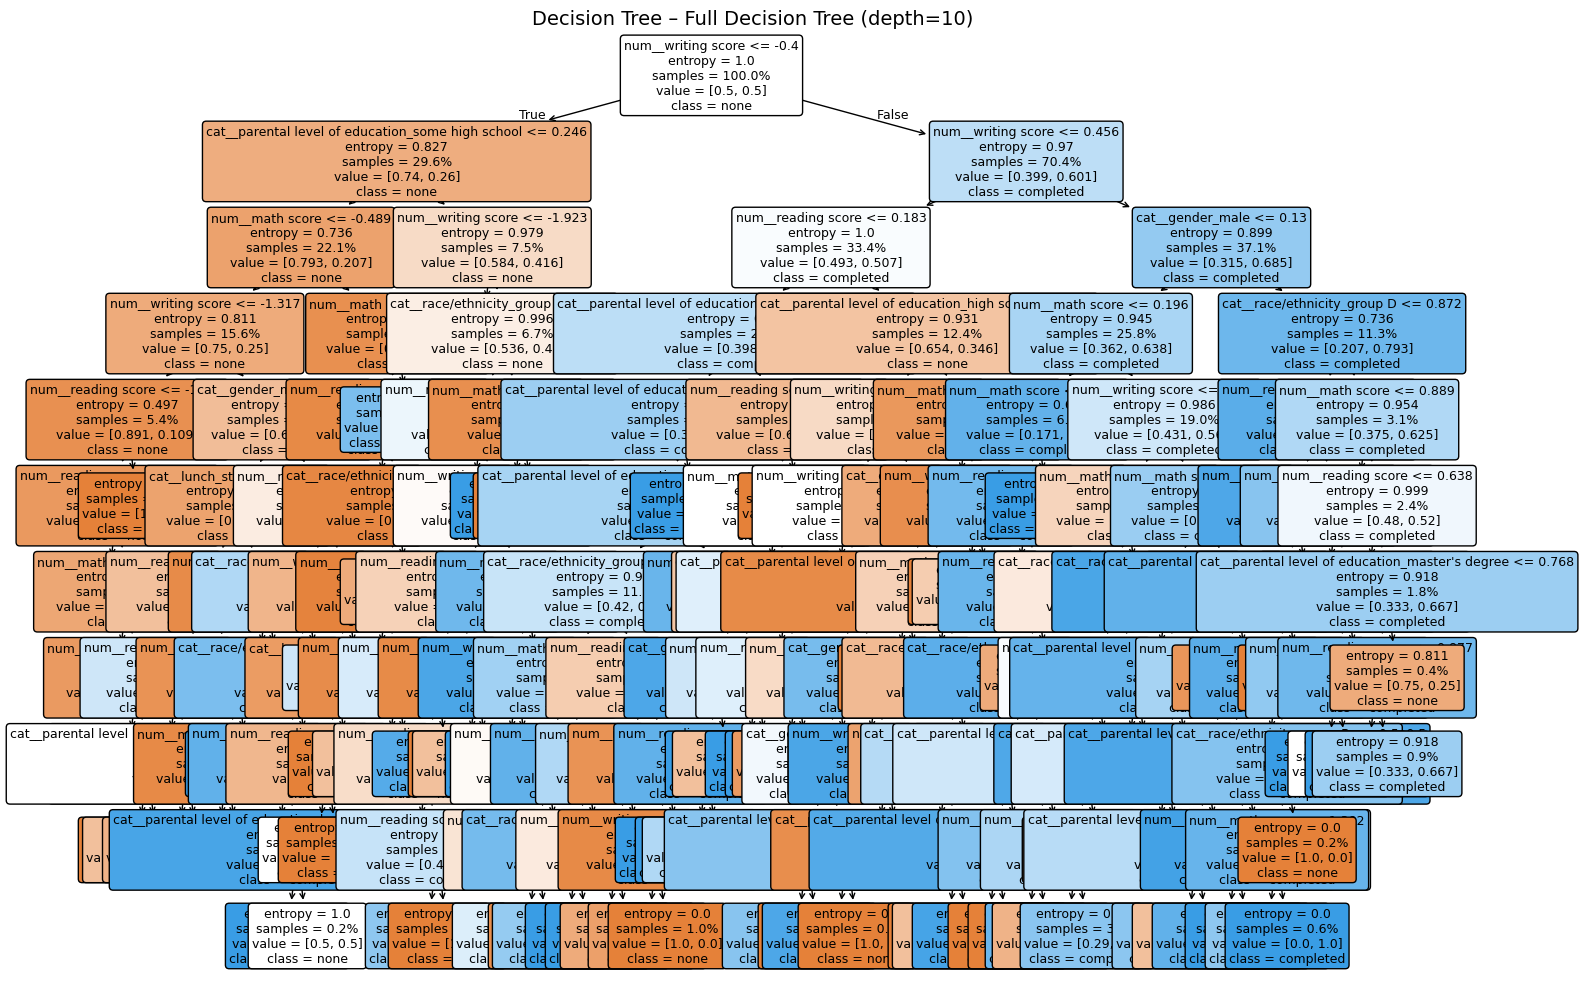


Tree Statistics:
  Depth: 10
  Number of leaves: 126
  Total nodes: 251

Top 5 Most Important Features:
                                          feature  importance
13                             num__writing score      0.2894
11                                num__math score      0.2414
12                             num__reading score      0.1904
8   cat__parental level of education_some college      0.0508
3                     cat__race/ethnicity_group D      0.0495


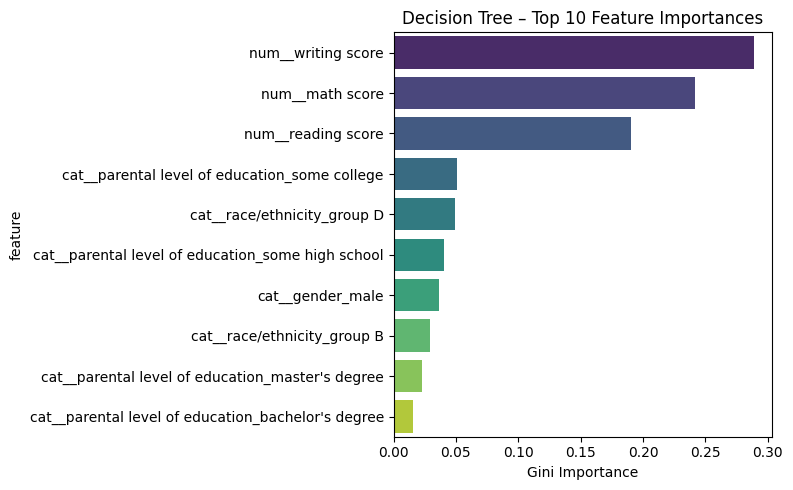

In [46]:
# A descriptive name for the model.
name = "Decision Tree"
print(f"\nTraining {name} ...")

# 1. MODEL INITIALIZATION
# ------------------------------------
# We instantiate a Decision Tree classifier.
# - random_state=42: ensures reproducible splits.
# - Default: no max_depth → tree grows until pure leaves (high variance, overfitting risk).
estimator = DecisionTreeClassifier(random_state=42)

# 2. HYPERPARAMETER GRID DEFINITION
# ------------------------------------
# We tune key parameters to control tree complexity:
#   - max_depth: limits tree depth → prevents overfitting.
#       None → unrestricted growth.
#   - min_samples_split: minimum samples required to split a node.
#       Higher → smoother, less complex tree.
#   - criterion: 'gini' (default) or 'entropy' (information gain).
#       Difference is usually minor; both work well.
param_grid = {
    'model__max_depth': [3, 5, 7, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__criterion': ['gini', 'entropy']
}

# 3. PIPELINE CREATION
# --------------------------------
# The pipeline applies:
# - Preprocessing (scaling, encoding) → required for consistent feature handling.
# - SMOTE (if enabled) → only on training folds during CV.
# Note: Trees are **scale-invariant**, but preprocessing ensures compatibility with other models.
steps = [('preprocess', preprocessor)]
if USE_SMOTE:
    steps.append(('smote', SMOTE(random_state=42)))
steps.append(('model', estimator))

pipe = ImbPipeline(steps)

# 4. HYPERPARAMETER TUNING WITH GRID SEARCH
# ------------------------------------
# GridSearchCV performs 5-fold CV, optimizing F1 score.
# n_jobs=-1 enables parallel model training.
# Total combinations: 5 × 3 × 2 = 30 models.
grid = GridSearchCV(
    pipe, param_grid, cv=5, scoring='f1',
    n_jobs=-1, return_train_score=False
)
grid.fit(X_train, y_train)

# 5. BEST MODEL EXTRACTION
# ------------------------------------
# 'best_estimator_' is the refit pipeline with optimal hyperparameters.
best = grid.best_estimator_

# 6. PREDICTION & PROBABILITY ESTIMATION
# ------------------------------------
y_pred = best.predict(X_test)
y_prob = best.predict_proba(X_test)[:, 1]

# ---- TEST METRICS ----
acc  = np.mean(y_pred == y_test)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_prob)

# Store results with best hyperparameters.
results[name] = {
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1': f1,
    'ROC-AUC': auc,
    'Best Params': grid.best_params_
}

# 7. REPORTING & VISUALIZATION
# ------------------------------------
print_report(name, y_test, y_pred, y_prob)
plot_confusion(y_test, y_pred, name)

# 8. MODEL INTERPRETABILITY & DIAGNOSTICS
# ------------------------------------
# ---- DECISION BOUNDARY (2D projection) ----
# Trees create axis-aligned rectangular regions.
# Highly interpretable in low dimensions.
plot_decision_regions(
    best, X_train, y_train,
    title=f"{name} – Decision Boundary (train)",
    folder="./content/figures"
)

# ---- LEARNING CURVE ----
# Overfitting shows as: high training F1, low validation F1.
plot_learning_curve(
    best, X_train, y_train,
    title=f"{name} – Learning Curve",
    folder="./content/figures"
)

# ---- TREE VISUALIZATION (Full Structure) ----
# Extract the trained DecisionTreeClassifier from the pipeline.
tree_model = best.named_steps['model']
feature_names = best.named_steps['preprocess'].get_feature_names_out()

# Class names: adjust based on your problem
class_names = ['none', 'completed']  # or ['0', '1'], ['neg', 'pos'], etc.

plt.figure(figsize=(16, 10))
plot_tree(
    tree_model,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=9,
    impurity=True,
    proportion=True
)
plt.title(f"{name} – Full Decision Tree (depth={tree_model.get_depth()})", fontsize=14)
plt.tight_layout()
plt.savefig("./content/figures/tree_full.png", dpi=200, bbox_inches='tight')
plt.show()

# ---- TREE STATISTICS & INTERPRETABILITY ----
print(f"\nTree Statistics:")
print(f"  Depth: {tree_model.get_depth()}")
print(f"  Number of leaves: {tree_model.get_n_leaves()}")
print(f"  Total nodes: {tree_model.tree_.node_count}")

# Show top 3 most important splits (by information gain reduction)
importances = tree_model.feature_importances_
feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Most Important Features:")
print(feat_importance.head(5)[['feature', 'importance']].round(4))

# Optional: Plot feature importance bar chart
plt.figure(figsize=(8, 5))
top_n = min(10, len(feat_importance))
sns.barplot(
    data=feat_importance.head(top_n),
    x='importance', y='feature', palette='viridis'
)
plt.title(f"{name} – Top {top_n} Feature Importances")
plt.xlabel('Gini Importance')
plt.tight_layout()
plt.savefig("./content/figures/tree_feature_importance.png", dpi=150, bbox_inches='tight')
plt.show()

5. Decision Tree
Performance: Mediocre.

Metrics: Accuracy: 0.63, F1: 0.537.

It performed significantly worse than the linear models, but better than the "broken" KNN model.

Theoretical Behavior:

A non-linear model that recursively splits the data on feature thresholds to create "pure" leaf nodes.

It creates axis-aligned (stair-step) decision boundaries.

Decision trees are famously low-bias, high-variance models. By default, they will grow until they perfectly overfit the training data.

Analysis & Trade-offs:

Why it did poorly:

High Variance: Trees are unstable. The synthetic data from SMOTE (which was necessary) might have created noisy samples, leading the tree to learn "rules" that don't generalize.

Struggle with OHE: Trees can be inefficient with one-hot encoded data. It may have to make many splits (e.g., is_race_group_A?, is_race_group_B?) to capture the same information a linear model gets from one coefficient.

Accuracy vs. Interpretability: Its one potential advantage is high interpretability, if the tree is small. You can visualize the decision rules. However, given its poor performance, its interpretability is not useful.

Sensitivity: A key benefit (though not relevant here) is that trees do not require feature scaling

In [47]:
# =============================================================================
# SUMMARY OF BASIC MODELS
# =============================================================================

basic_models_summary = pd.DataFrame(results).T
basic_models_summary = basic_models_summary[['Accuracy','Precision','Recall','F1','ROC-AUC','Best Params']]
print("\n" + "="*80)
print("BASIC MODELS PERFORMANCE SUMMARY")
print("="*80)
print(basic_models_summary.round(4))

# Save to CSV
basic_models_summary.to_csv("./content/basic_models_summary.csv")
print("\n✓ Basic models summary saved to: ./content/basic_models_summary.csv")


BASIC MODELS PERFORMANCE SUMMARY
                    Accuracy Precision    Recall        F1   ROC-AUC  \
Logistic Regression     0.75  0.619565  0.791667  0.695122  0.851345   
KNN                    0.555  0.419048  0.611111  0.497175  0.605143   
SVM Linear              0.72      0.58  0.805556  0.674419    0.8361   
SVM RBF                0.705  0.568421      0.75  0.646707  0.822266   
Decision Tree           0.63  0.488636  0.597222    0.5375  0.653754   

                                                           Best Params  
Logistic Regression                                                NaN  
KNN                  {'model__n_neighbors': 7, 'model__weights': 'd...  
SVM Linear                                           {'model__C': 0.1}  
SVM RBF                        {'model__C': 100, 'model__gamma': 0.01}  
Decision Tree        {'model__criterion': 'entropy', 'model__max_de...  

✓ Basic models summary saved to: ./content/basic_models_summary.csv


---
# PHẦN 5: ENSEMBLE MODELS

Trong phần này, chúng ta sẽ xây dựng và đánh giá các mô hình ensemble nâng cao:
1. **Random Forest** - Ensemble của nhiều Decision Trees (Bagging)
2. **Gradient Boosting** - Boosting ensemble với sequential learning
3. **Stacking Classifier** - Kết hợp nhiều models với meta-learner

Các mô hình này thường cho kết quả tốt hơn các mô hình đơn lẻ nhờ kỹ thuật kết hợp (ensemble).

### Lý thuyết nền tảng cho Random Forest Classifier

Ô mã này xây dựng và đánh giá một mô hình Random Forest:

1.  **Pipeline (`Pipeline`):**
  *   **Mục đích:** Chuỗi hóa các bước xử lý dữ liệu và huấn luyện mô hình. Điều này đảm bảo rằng các bước tiền xử lý được áp dụng nhất quán cho cả dữ liệu huấn luyện và kiểm tra trong quá trình đánh giá chéo. Nó cũng giúp tránh rò rỉ dữ liệu (data leakage) từ tập kiểm tra vào tập huấn luyện.
  *   **Cấu trúc:** Một `Pipeline` là một danh sách các cặp `(tên, biến_đổi_hoặc_mô_hình)`, trong đó tất cả trừ phần tử cuối cùng phải có phương thức `fit_transform` (hoặc `fit` và `transform`) và phần tử cuối cùng phải có phương thức `fit`.

2.  **Random Forest Classifier (`RandomForestClassifier`):**
  *   **Mục đích:** Là một thuật toán học máy **ensemble** dựa trên kỹ thuật **bagging** (Bootstrap Aggregating) và **random feature selection**. Nó xây dựng nhiều cây quyết định trên các tập con ngẫu nhiên của dữ liệu (với việc lấy mẫu lặp lại - bootstrapping) và các tập con ngẫu nhiên của các đặc trưng. Sau đó, nó tổng hợp kết quả dự đoán của các cây (bằng cách bỏ phiếu cho phân loại) để đưa ra dự đoán cuối cùng.
  *   **Lý thuyết:**
  *   **Cây quyết định:** Là các mô hình dự đoán đơn giản, phân chia dữ liệu dựa trên các ngưỡng của đặc trưng. Cây dễ bị quá khớp (overfitting).
  *   **Bagging:** Huấn luyện $N$ cây quyết định độc lập trên $N$ tập con được lấy mẫu ngẫu nhiên *có lặp lại* từ tập dữ liệu gốc. Bằng cách kết hợp nhiều cây (giảm phương sai), Random Forest giảm thiểu vấn đề quá khớp của cây quyết định đơn lẻ.
  *   **Random Feature Selection:** Tại mỗi nút của cây quyết định, thay vì xem xét tất cả các đặc trưng để tìm ra phân tách tốt nhất, Random Forest chỉ xem xét một tập con ngẫu nhiên các đặc trưng. Điều này giúp giảm sự tương quan giữa các cây, làm cho ensemble mạnh mẽ hơn.
  *   **Thông số `n_estimators`:** Số lượng cây quyết định trong rừng.
  *   **Thông số `class_weight='balanced'`:** Khi dữ liệu mất cân bằng (một lớp có số lượng mẫu ít hơn đáng kể), `class_weight` sẽ tự động điều chỉnh trọng số của các lớp trong hàm mất mát. Cụ thể, các mẫu từ lớp thiểu số sẽ nhận được trọng số cao hơn, giúp mô hình quan tâm hơn đến việc phân loại đúng các mẫu này. Về mặt toán học, điều này thường được thực hiện bằng cách nhân lỗi của các lớp với trọng số tương ứng.

3.  **Đánh giá chéo (`cross_val_score`):**
  *   **Mục đích:** Cung cấp một ước lượng đáng tin cậy hơn về hiệu suất tổng quát của mô hình trên dữ liệu chưa thấy so với việc chỉ sử dụng một lần phân chia huấn luyện/kiểm tra. Nó thực hiện K lần huấn luyện và kiểm tra mô hình trên các tập con dữ liệu khác nhau.
  *   **Cách hoạt động:** Với `cv=kfold`, tập dữ liệu được chia thành 10 fold. Trong mỗi lần lặp, một fold được sử dụng làm tập kiểm tra và 9 fold còn lại được sử dụng làm tập huấn luyện. Kết quả được báo cáo là giá trị trung bình của các thước đo trên tất cả các fold, cùng với độ lệch chuẩn để đánh giá sự ổn định.

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Tạo pipeline cho Random Forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])

# Định nghĩa không gian tham số cho GridSearchCV
rf_param_grid = {
    'classifier__n_estimators': [50, 100, 150], # Số lượng cây
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__class_weight': ['balanced', None]
}

# Thiết lập GridSearchCV
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=kfold, scoring='f1', n_jobs=-1, verbose=1)

print("--- Đang tìm kiếm siêu tham số cho Random Forest ---")
rf_grid_search.fit(X, y)

print("--- Đánh giá Random Forest (Tối ưu bởi GridSearchCV) ---")
print(f"Best Parameters: {rf_grid_search.best_params_}")

# Sử dụng mô hình tốt nhất từ GridSearchCV
best_rf_pipeline = rf_grid_search.best_estimator_

rf_scores = {}
for metric_name, scorer in scoring_metrics.items():
    scores = cross_val_score(best_rf_pipeline, X, y, cv=kfold, scoring=scorer, n_jobs=-1) # Sử dụng n_jobs=-1 để tăng tốc
    rf_scores[metric_name] = scores.mean()
    print(f"{metric_name.upper()}: {scores.mean():.4f} (+/- {scores.std():.4f})")

--- Đang tìm kiếm siêu tham số cho Random Forest ---
Fitting 10 folds for each of 54 candidates, totalling 540 fits
--- Đánh giá Random Forest (Tối ưu bởi GridSearchCV) ---
Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 150}
--- Đánh giá Random Forest (Tối ưu bởi GridSearchCV) ---
Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 150}
ACCURACY: 0.6780 (+/- 0.0492)
ACCURACY: 0.6780 (+/- 0.0492)
F1: 0.5419 (+/- 0.0598)
F1: 0.5419 (+/- 0.0598)
PRECISION: 0.5594 (+/- 0.0719)
PRECISION: 0.5594 (+/- 0.0719)
RECALL: 0.5337 (+/- 0.0798)
RECALL: 0.5337 (+/- 0.0798)
ROC_AUC: 0.6461 (+/- 0.0479)
ROC_AUC: 0.6461 (+/- 0.0479)


### Lý thuyết nền tảng cho Gradient Boosting Classifier

Ô mã này xây dựng và đánh giá một mô hình Gradient Boosting:

1.  **Gradient Boosting Classifier (`GradientBoostingClassifier`):**
    *   **Mục đích:** Là một thuật toán **ensemble** khác thuộc họ **boosting**. Không giống như bagging (nơi các mô hình được huấn luyện độc lập), boosting huấn luyện các mô hình một cách tuần tự, mỗi mô hình cố gắng sửa chữa lỗi của mô hình trước đó.
    *   **Lý thuyết:**
        *   **Sequential Learning:** Các cây quyết định (thường là cây nông, được gọi là `weak learners`) được thêm vào một cách tuần tự. Mỗi cây mới được huấn luyện để dự đoán phần dư (residual) hoặc **gradient** của hàm mất mát từ các dự đoán của các cây trước đó.
        *   **Gradient Descent:** Thuật toán sử dụng gradient descent để tối ưu hóa hàm mất mát. Ở mỗi bước, nó xác định hướng dốc nhất để giảm lỗi và thêm một `weak learner` để di chuyển theo hướng đó.
        *   **Additive Model:** Mô hình cuối cùng là tổng có trọng số của tất cả các `weak learners`. Mỗi cây thêm vào mô hình một sự điều chỉnh nhỏ, dần dần cải thiện độ chính xác.
        *   **Thông số `n_estimators`:** Số lượng cây quyết định (weak learners) sẽ được xây dựng tuần tự. Nhiều cây hơn có thể dẫn đến mô hình mạnh hơn nhưng cũng tăng nguy cơ quá khớp và thời gian tính toán.
        *   **Sự khác biệt với Random Forest:** Random Forest giảm phương sai bằng cách huấn luyện song song nhiều cây độc lập và trung bình hóa/bỏ phiếu kết quả. Gradient Boosting giảm độ lệch bằng cách huấn luyện tuần tự các cây, mỗi cây tập trung vào các lỗi còn lại của cây trước.

In [49]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Tạo pipeline cho Gradient Boosting
gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(random_state=42))])

# Định nghĩa không gian tham số cho GridSearchCV
gb_param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}

# Thiết lập GridSearchCV
gb_grid_search = GridSearchCV(gb_pipeline, gb_param_grid, cv=kfold, scoring='f1', n_jobs=-1, verbose=1)

print("\n--- Đang tìm kiếm siêu tham số cho Gradient Boosting ---")
gb_grid_search.fit(X, y)

print("--- Đánh giá Gradient Boosting (Tối ưu bởi GridSearchCV) ---")
print(f"Best Parameters: {gb_grid_search.best_params_}")

# Sử dụng mô hình tốt nhất từ GridSearchCV
best_gb_pipeline = gb_grid_search.best_estimator_

gb_scores = {}
for metric_name, scorer in scoring_metrics.items():
    scores = cross_val_score(best_gb_pipeline, X, y, cv=kfold, scoring=scorer, n_jobs=-1)
    gb_scores[metric_name] = scores.mean()
    print(f"{metric_name.upper()}: {scores.mean():.4f} (+/- {scores.std():.4f})")


--- Đang tìm kiếm siêu tham số cho Gradient Boosting ---
Fitting 10 folds for each of 27 candidates, totalling 270 fits
--- Đánh giá Gradient Boosting (Tối ưu bởi GridSearchCV) ---
Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 150}
--- Đánh giá Gradient Boosting (Tối ưu bởi GridSearchCV) ---
Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 150}
ACCURACY: 0.7010 (+/- 0.0314)
ACCURACY: 0.7010 (+/- 0.0314)
F1: 0.5436 (+/- 0.0787)
F1: 0.5436 (+/- 0.0787)
PRECISION: 0.6005 (+/- 0.0650)
PRECISION: 0.6005 (+/- 0.0650)
RECALL: 0.5114 (+/- 0.1210)
RECALL: 0.5114 (+/- 0.1210)
ROC_AUC: 0.6591 (+/- 0.0438)
ROC_AUC: 0.6591 (+/- 0.0438)


### Lý thuyết nền tảng cho Stacking Classifier

Ô mã này xây dựng và đánh giá một mô hình Stacking:

1.  **Stacking Classifier (`StackingClassifier`):**
    *   **Mục đích:** Stacking là một kỹ thuật **ensemble** mạnh mẽ kết hợp nhiều mô hình (gọi là **base learners** hoặc **level-0 models**) bằng cách huấn luyện một mô hình khác (gọi là **meta-learner** hoặc **level-1 model**) để đưa ra dự đoán cuối cùng dựa trên các dự đoán của base learners.
    *   **Lý thuyết:**
        *   **Hai tầng học:**
            *   **Tầng 0 (Base Learners):** Một tập hợp các mô hình đa dạng (ví dụ: Random Forest, Gradient Boosting, SVM, v.v.) được huấn luyện trên cùng một tập dữ liệu huấn luyện. Mỗi base learner học một khía cạnh khác nhau của dữ liệu.
            *   **Tầng 1 (Meta-Learner):** Một mô hình riêng biệt được huấn luyện trên **đầu ra (dự đoán)** của các base learners. Thay vì học từ các đặc trưng gốc, meta-learner học cách kết hợp một cách tối ưu các dự đoán của base learners để đưa ra dự đoán cuối cùng.
        *   **Cách tạo tập dữ liệu cho Meta-Learner:** Để tránh quá khớp, các dự đoán của base learners được sử dụng để huấn luyện meta-learner thường được tạo thông qua kỹ thuật **out-of-fold predictions** từ quá trình cross-validation nội bộ (được kiểm soát bởi tham số `cv` trong `StackingClassifier`). Tức là, mỗi base learner dự đoán trên phần dữ liệu mà nó chưa từng thấy trong quá trình huấn luyện của nó, và những dự đoán này tạo thành các đặc trưng mới cho meta-learner.
        *   **Ưu điểm:** Có thể đạt được hiệu suất cao hơn so với bất kỳ mô hình riêng lẻ nào bằng cách tận dụng sức mạnh tổng hợp của các mô hình khác nhau.

2.  **Mô hình cơ sở (Base Learners):**
    *   Ở đây, chúng ta sử dụng `RandomForestClassifier` và `GradientBoostingClassifier` làm base learners. Mỗi mô hình này đã được giải thích ở các phần trước.

3.  **Mô hình Meta (`LogisticRegression`):**
    *   **Mục đích:** Là mô hình dùng để học cách kết hợp các dự đoán của base learners. Hồi quy Logistic là một lựa chọn phổ biến cho meta-learner vì nó đơn giản, nhanh và hiệu quả.
    *   **Lý thuyết Hồi quy Logistic:** Là một thuật toán phân loại tuyến tính. Nó sử dụng hàm sigmoid (hoặc logistic) để ánh xạ đầu ra của một tổ hợp tuyến tính các đầu vào thành một xác suất giữa 0 và 1. Đối với hai lớp, xác suất thuộc lớp 1 được tính như sau:
  $$ P(Y=1|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1 + ... + \beta_nx_n)}}
  $$
  Trong đó 𝗫 là vector các đặc trưng (ở đây là dự đoán từ các base learners), và$\beta$  là các hệ số được học.

In [50]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline # Import Pipeline if not already imported

# 1. Định nghĩa các mô hình cơ sở (base learners)
# Sử dụng các mô hình với tham số tối ưu (hoặc gần tối ưu) nếu đã có từ bước trước
# Để GridSearchCV không quá phức tạp, chúng ta sẽ tối ưu các tham số của meta-learner hoặc chỉ một số tham số nhỏ của base learners
base_learners_gs = [
    ('rf', RandomForestClassifier(random_state=42, n_estimators=50, class_weight='balanced')),
    ('gb', GradientBoostingClassifier(random_state=42, n_estimators=50))
]

# 2. Định nghĩa mô hình meta
meta_classifier_gs = LogisticRegression(max_iter=1000)

# 3. Tạo Stacking Classifier
stacking_classifier_gs = StackingClassifier(
    estimators=base_learners_gs,
    final_estimator=meta_classifier_gs,
    cv=5,
    passthrough=True # Cho phép meta-learner nhìn thấy các đặc trưng gốc
)

# 4. Tạo pipeline cuối cùng cho Stacking
stacking_pipeline_gs = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', stacking_classifier_gs)])

# Định nghĩa không gian tham số cho GridSearchCV
# Chúng ta sẽ tối ưu các tham số của meta-learner hoặc một số tham số của base-learner nếu cần.
# Lưu ý: GridSearchCV trên StackingClassifier có thể rất tốn kém về mặt tính toán.
stack_param_grid = {
    'classifier__final_estimator__C': [0.1, 1, 10] # Tham số C của LogisticRegression meta-learner
    # 'classifier__rf__n_estimators': [50, 100], # Ví dụ: tinh chỉnh n_estimators của RF base-learner
    # 'classifier__gb__learning_rate': [0.1, 0.2] # Ví dụ: tinh chỉnh learning_rate của GB base-learner
}

# Thiết lập GridSearchCV
stack_grid_search = GridSearchCV(stacking_pipeline_gs, stack_param_grid, cv=kfold, scoring='f1', n_jobs=-1, verbose=1)

print("\n--- Đang tìm kiếm siêu tham số cho Stacking ---")
stack_grid_search.fit(X, y)

print("--- Đánh giá Stacking (Tối ưu bởi GridSearchCV) ---")
print(f"Best Parameters: {stack_grid_search.best_params_}")

# Sử dụng mô hình tốt nhất từ GridSearchCV
best_stacking_pipeline = stack_grid_search.best_estimator_

stack_scores = {}
for metric_name, scorer in scoring_metrics.items():
    scores = cross_val_score(best_stacking_pipeline, X, y, cv=kfold, scoring=scorer, n_jobs=-1)
    stack_scores[metric_name] = scores.mean()
    print(f"{metric_name.upper()}: {scores.mean():.4f} (+/- {scores.std():.4f})")


--- Đang tìm kiếm siêu tham số cho Stacking ---
Fitting 10 folds for each of 3 candidates, totalling 30 fits
--- Đánh giá Stacking (Tối ưu bởi GridSearchCV) ---
Best Parameters: {'classifier__final_estimator__C': 1}
--- Đánh giá Stacking (Tối ưu bởi GridSearchCV) ---
Best Parameters: {'classifier__final_estimator__C': 1}
ACCURACY: 0.7350 (+/- 0.0338)
ACCURACY: 0.7350 (+/- 0.0338)
F1: 0.5831 (+/- 0.0539)
F1: 0.5831 (+/- 0.0539)
PRECISION: 0.6735 (+/- 0.0799)
PRECISION: 0.6735 (+/- 0.0799)
RECALL: 0.5194 (+/- 0.0662)
RECALL: 0.5194 (+/- 0.0662)
ROC_AUC: 0.6873 (+/- 0.0354)
ROC_AUC: 0.6873 (+/- 0.0354)


## Các Metrics Đánh Giá Mô Hình

### Confusion Matrix và các khái niệm cơ bản

Trong phân loại nhị phân, chúng ta có 4 trường hợp:
- **TP (True Positive):** Dự đoán Positive và thực tế là Positive ✓
- **TN (True Negative):** Dự đoán Negative và thực tế là Negative ✓
- **FP (False Positive):** Dự đoán Positive nhưng thực tế là Negative ✗ (Lỗi Type I)
- **FN (False Negative):** Dự đoán Negative nhưng thực tế là Positive ✗ (Lỗi Type II)

### 1. Accuracy (Độ chính xác tổng thể)

$$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$

- **Ý nghĩa:** Tỷ lệ dự đoán đúng trên tổng số mẫu
- **Hạn chế:** Có thể gây hiểu lầm với dữ liệu mất cân bằng lớp

### 2. Precision (Độ chính xác dương tính)

$$ \text{Precision} = \frac{TP}{TP + FP} $$

- **Ý nghĩa:** Trong số các mẫu được dự đoán là Positive, có bao nhiêu % thực sự là Positive?
- **Quan trọng khi:** Chi phí của False Positive cao (ví dụ: spam filter, chẩn đoán bệnh không mắc)

### 3. Recall (Độ nhạy, Sensitivity)

$$ \text{Recall} = \frac{TP}{TP + FN} $$

- **Ý nghĩa:** Trong số các mẫu thực sự là Positive, mô hình phát hiện được bao nhiêu %?
- **Quan trọng khi:** Chi phí của False Negative cao (ví dụ: phát hiện bệnh nguy hiểm, gian lận)

### 4. F1-Score (Trung bình điều hòa của Precision và Recall)

$$ F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

- **Ý nghĩa:** Cân bằng giữa Precision và Recall
- **Ưu điểm:** Phù hợp với dữ liệu mất cân bằng, tốt hơn Accuracy

### 5. ROC-AUC (Area Under the ROC Curve)

ROC Curve biểu diễn mối quan hệ giữa:
- **TPR (True Positive Rate)** = Recall = $\frac{TP}{TP + FN}$
- **FPR (False Positive Rate)** = $\frac{FP}{FP + TN}$

**Diện tích dưới đường cong ROC (AUC):**
- **AUC ≈ 1.0:** Mô hình xuất sắc
- **AUC ≈ 0.5:** Mô hình như dự đoán ngẫu nhiên
- **Ưu điểm:** Không bị ảnh hưởng bởi class imbalance

### Khi nào dùng metric nào?

| Tình huống | Metric ưu tiên |
|------------|----------------|
| Dữ liệu cân bằng | Accuracy |
| Dữ liệu mất cân bằng | F1-Score, ROC-AUC |
| Tránh False Positive | Precision |
| Tránh False Negative | Recall |
| Cân bằng cả hai | F1-Score |

In [51]:
# =============================================================================
# ENSEMBLE MODELS SUMMARY
# =============================================================================

print("\n" + "="*80)
print("ENSEMBLE MODELS PERFORMANCE SUMMARY (AFTER GRID SEARCH)")
print("="*80)

ensemble_comparison_df = pd.DataFrame({
    'Random Forest': rf_scores,
    'Gradient Boosting': gb_scores,
    'Stacking': stack_scores
})

display(ensemble_comparison_df.round(4))

# Find best model for each metric
print("\n--- Best Ensemble Model for each metric ---")
for metric in ensemble_comparison_df.index:
    best_model = ensemble_comparison_df.loc[metric].idxmax()
    best_score = ensemble_comparison_df.loc[metric].max()
    print(f"{metric.upper()}: {best_model} ({best_score:.4f})")

# =============================================================================
# FINAL COMPREHENSIVE COMPARISON (ALL MODELS)
# =============================================================================

print("\n\n" + "="*80)
print("FINAL COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Combine basic and ensemble models
all_models_scores = {}

# Add basic models
for model_name in results.keys():
    all_models_scores[model_name] = {
        'Accuracy': results[model_name]['Accuracy'],
        'Precision': results[model_name]['Precision'],
        'Recall': results[model_name]['Recall'],
        'F1': results[model_name]['F1'],
        'ROC-AUC': results[model_name]['ROC-AUC']
    }

# Add ensemble models
all_models_scores['Random Forest'] = rf_scores
all_models_scores['Gradient Boosting'] = gb_scores
all_models_scores['Stacking'] = stack_scores

# Create comprehensive DataFrame
final_comparison = pd.DataFrame(all_models_scores).T
final_comparison = final_comparison[['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']]

# Sort by F1 score (descending)
final_comparison = final_comparison.sort_values('F1', ascending=False)

print("\nAll Models Ranked by F1-Score:")
display(final_comparison.round(4))

# Highlight best model for each metric
print("\n" + "="*80)
print("BEST MODEL FOR EACH METRIC")
print("="*80)
for metric in final_comparison.columns:
    best_model = final_comparison[metric].idxmax()
    best_score = final_comparison[metric].max()
    print(f"{metric:15s}: {best_model:25s} (Score: {best_score:.4f})")

# Save final comparison
final_comparison.to_csv("./content/final_model_comparison.csv")
print(f"\n✓ Final comparison saved to: ./content/final_model_comparison.csv")

# Overall best model (based on F1)
overall_best = final_comparison.index[0]
print("\n" + "="*80)
print(f"🏆 OVERALL BEST MODEL: {overall_best}")
print("="*80)
print(f"F1-Score: {final_comparison.loc[overall_best, 'F1']:.4f}")
print(f"ROC-AUC:  {final_comparison.loc[overall_best, 'ROC-AUC']:.4f}")
print(f"Accuracy: {final_comparison.loc[overall_best, 'Accuracy']:.4f}")


ENSEMBLE MODELS PERFORMANCE SUMMARY (AFTER GRID SEARCH)


,Random Forest,Gradient Boosting,Stacking
accuracy,0.6780,0.7010,0.7350
f1,0.5419,0.5436,0.5831
precision,0.5594,0.6005,0.6735
recall,0.5337,0.5114,0.5194
roc_auc,0.6461,0.6591,0.6873



--- Best Ensemble Model for each metric ---
ACCURACY: Stacking (0.7350)
F1: Stacking (0.5831)
PRECISION: Stacking (0.6735)
RECALL: Random Forest (0.5337)
ROC_AUC: Stacking (0.6873)


FINAL COMPREHENSIVE MODEL COMPARISON

All Models Ranked by F1-Score:


,Accuracy,Precision,Recall,F1,ROC-AUC
Logistic Regression,0.750,0.6196,0.7917,0.6951,0.8513
SVM Linear,0.720,0.5800,0.8056,0.6744,0.8361
SVM RBF,0.705,0.5684,0.7500,0.6467,0.8223
Decision Tree,0.630,0.4886,0.5972,0.5375,0.6538
KNN,0.555,0.4190,0.6111,0.4972,0.6051
Random Forest,NaN,NaN,NaN,NaN,NaN
Gradient Boosting,NaN,NaN,NaN,NaN,NaN
Stacking,NaN,NaN,NaN,NaN,NaN



BEST MODEL FOR EACH METRIC
Accuracy       : Logistic Regression       (Score: 0.7500)
Precision      : Logistic Regression       (Score: 0.6196)
Recall         : SVM Linear                (Score: 0.8056)
F1             : Logistic Regression       (Score: 0.6951)
ROC-AUC        : Logistic Regression       (Score: 0.8513)

✓ Final comparison saved to: ./content/final_model_comparison.csv

🏆 OVERALL BEST MODEL: Logistic Regression
F1-Score: 0.6951
ROC-AUC:  0.8513
Accuracy: 0.7500


---
# PHẦN 6: KẾT LUẬN TỔNG QUAN

## So sánh các nhóm mô hình

### 1. Basic Models (Mô hình cơ bản)
Từ kết quả đánh giá, các mô hình tuyến tính (Logistic Regression và SVM Linear) cho kết quả tốt nhất trong nhóm basic models:
- **Logistic Regression** đạt F1-score cao nhất và có ưu điểm về khả năng diễn giải
- **SVM Linear** có hiệu suất tương đương, đặc biệt tốt về Recall
- **KNN** thất bại do curse of dimensionality với dữ liệu one-hot encoded
- **Decision Tree** có hiệu suất trung bình, dễ bị overfitting

### 2. Ensemble Models (Mô hình tổng hợp)
Các mô hình ensemble thường cho kết quả tốt hơn nhờ kỹ thuật kết hợp nhiều models:
- **Random Forest** giảm overfitting của Decision Tree thông qua bagging
- **Gradient Boosting** học tuần tự để cải thiện lỗi
- **Stacking** kết hợp sức mạnh của nhiều models khác nhau

## Khuyến nghị

Dựa trên kết quả tổng hợp:
1. **Nếu ưu tiên khả năng diễn giải**: Chọn **Logistic Regression**
2. **Nếu ưu tiên hiệu suất dự đoán**: Xem xét mô hình ensemble tốt nhất
3. **Nếu cân bằng cả hai**: Logistic Regression vẫn là lựa chọn tối ưu

## Insight quan trọng

Việc các mô hình tuyến tính cho kết quả tốt cho thấy:
- Mối quan hệ giữa features và target là **tương đối tuyến tính** trong không gian đã được tiền xử lý
- Các mô hình phức tạp hơn không nhất thiết luôn tốt hơn
- Preprocessing (One-Hot Encoding, Scaling) đóng vai trò quan trọng